# Libraries & Paths

In [1]:
# !pip install ultralytics
# !pip install -U ipywidgets

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from ultralytics import YOLO


/Users/renatoboemer/.pyenv/versions/3.10.6/envs/v1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
root_dir = os.getcwd()
images_dir = os.path.join(root_dir, "data", "images")
train_data = os.path.join(root_dir, "data", "images", "train_images")
test_data = os.path.join(root_dir, "data", "images", "val_images")
csv_data = os.path.join(root_dir, "data/train_solution_bounding_boxes.csv")


print(f'root_dir: {root_dir}')
print(f'train_data: {train_data}')
print(f'val_data: {test_data}')

root_dir: /Users/renatoboemer/code/developer/object-tracking/yolov8
train_data: /Users/renatoboemer/code/developer/object-tracking/yolov8/data/images/train_images
val_data: /Users/renatoboemer/code/developer/object-tracking/yolov8/data/images/val_images


# Check the data

In [4]:
df = pd.read_csv(csv_data)
df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [5]:
def plot_bounding_box_distribution(df):
    # calculate width and height
    df['width'] = df['xmax'] - df['xmin']
    df['height'] = df['ymax'] - df['ymin']

    # create the plot
    plt.figure(figsize=(10, 4))
    sns.scatterplot(x='width', y='height', data=df)
    plt.title('Distribution of bounding box sizes')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.show()


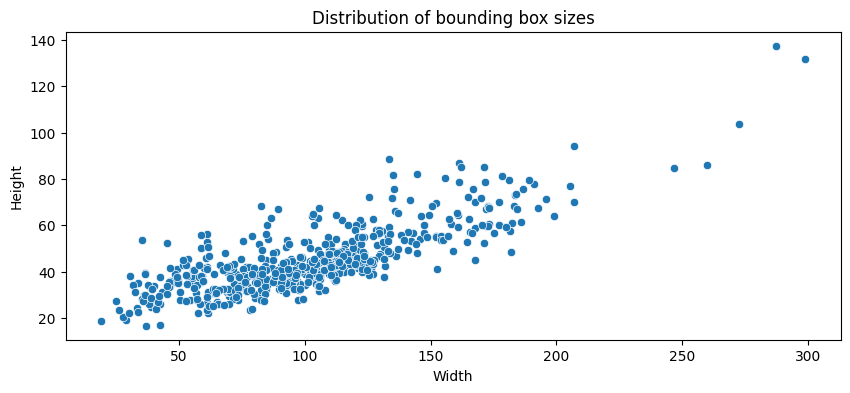

In [6]:
plot_bounding_box_distribution(df)

In [7]:
def plot_images_with_boxes(image_path, df, n=12):
    # limit n to 4 for a 2x2 grid
    n = min(n, 4)
    images = [os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith('.jpg')][:n]
    num_images = len(images)

    # Create a 2x2 grid for plotting
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs = axs.flatten()  # Flatten the 2x2 grid for easier iteration

    for i, img_path in enumerate(images):
        img = cv2.imread(img_path)
        img_name = os.path.basename(img_path)
        boxes = df[df['image'] == img_name]

        # Draw bounding boxes on the image
        for _, box in boxes.iterrows():
            cv2.rectangle(img,
                          (int(box['xmin']), int(box['ymin'])),
                          (int(box['xmax']), int(box['ymax'])),
                          (0, 0, 255), 2)

        # Display the image in the grid
        axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i].set_title(img_name)
        axs[i].axis('off')

    # Hide any unused subplots if fewer than 4 images are available
    for j in range(num_images, 4):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

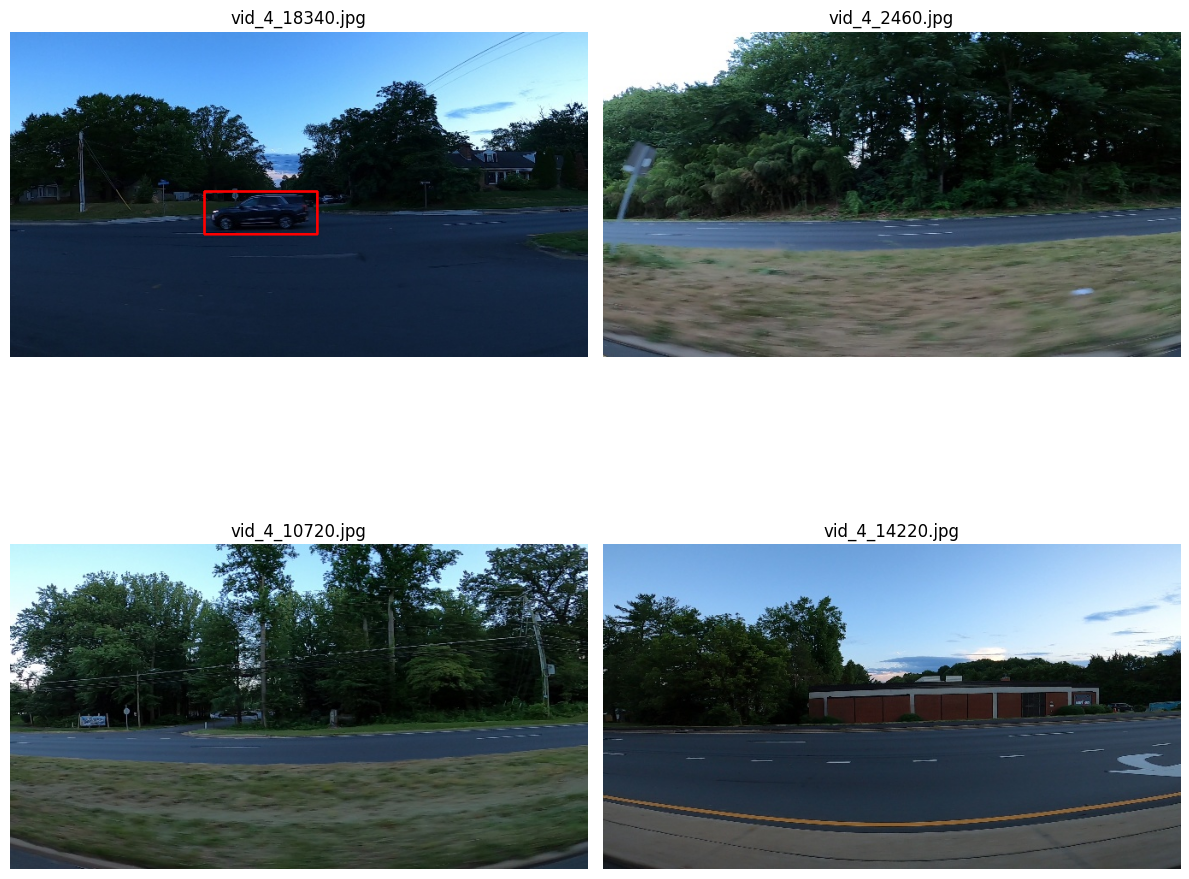

In [8]:
plot_images_with_boxes(train_data, df, n=12)

# Prepare the data

In [9]:
def create_yolo_annotation(row, img_width, img_height):
    x_center = ((row['xmin'] + row['xmax']) / 2) / img_width
    y_center = ((row['ymin'] + row['ymax']) / 2) / img_height

    width = (row['xmax'] - row['xmin']) / img_width
    height = (row['ymax'] - row['ymin']) / img_height

    return f'0 {x_center} {y_center} {width} {height}'

In [10]:
for img_name in df['image'].unique():
    img_df = df[df['image'] == img_name]
    img_path = os.path.join(train_data,img_name)
    img = cv2.imread(img_path)
    if img is not None:
        img_height, img_width = img.shape[:2]

        if np.random.rand() < 0.8:
            subset = "train_images"
        else:
            subset = "val_images"

        dst_img_path = os.path.join(images_dir, subset, img_name)
        cv2.imwrite(dst_img_path, img)

        annotation_path = os.path.join(images_dir, subset, f"{img_name.split('.')[0]}.txt")
        with open(annotation_path, 'w') as f:
            for _, row in img_df.iterrows():
                yolo_annotation = create_yolo_annotation(row, img_width, img_height)
                f.write(yolo_annotation + '\n')

In [11]:
config = f"""
path: {root_dir}
train: data/images/train_images
val: data/images/val_images

nc: 1
names: ['car']
"""
with open('config.yaml', 'w') as f:
    f.write(config)
print("YAML configuration file created.")

YAML configuration file created.


In [12]:
from ultralytics import YOLOv10

model = YOLOv10.from_pretrained('jameslahm/yolov10s')

# train the model
train_results = model.train(
    data='config.yaml',
    epochs=1,
    imgsz=640,
    batch=16,
    name='car_detection_model',
    optimizer='Adam',
    lr0=0.01,
    save_period=10,
    augment=True
)


New https://pypi.org/project/ultralytics/8.3.24 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.6 torch-2.2.2 CPU (Intel Core(TM) i7-4850HQ 2.30GHz)
engine/trainer: task=detect, mode=train, model=yolov10s.yaml, data=config.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=10, val_period=1, cache=False, device=None, workers=8, project=None, name=car_detection_model6, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, 

train: Scanning /Users/renatoboemer/code/developer/object-tracking/yolov8/data/labels/train_images... 0 images, 1001 backgrounds, 0 corrupt: 100%|██████████| 1001/1001 [00:00<00:00, 2104.19it/s]

train: WARNING ⚠️ No labels found in /Users/renatoboemer/code/developer/object-tracking/yolov8/data/labels/train_images.cache. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.
train: WARNING ⚠️ Cache directory /Users/renatoboemer/code/developer/object-tracking/yolov8/data/labels is not writeable, cache not saved.
WARNING ⚠️ No labels found in /Users/renatoboemer/code/developer/object-tracking/yolov8/data/labels/train_images.cache, training may not work correctly. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.



val: Scanning /Users/renatoboemer/code/developer/object-tracking/yolov8/data/labels/val_images... 0 images, 294 backgrounds, 0 corrupt: 100%|██████████| 294/294 [00:00<00:00, 2256.52it/s]

val: WARNING ⚠️ No labels found in /Users/renatoboemer/code/developer/object-tracking/yolov8/data/labels/val_images.cache. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.
val: WARNING ⚠️ Cache directory /Users/renatoboemer/code/developer/object-tracking/yolov8/data/labels is not writeable, cache not saved.
WARNING ⚠️ No labels found in /Users/renatoboemer/code/developer/object-tracking/yolov8/data/labels/val_images.cache, training may not work correctly. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.


Plotting labels to runs/detect/car_detection_model6/labels.jpg... 
zero-size array to reduction operation maximum which has no identity
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.0005), 111 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/car_detection_model6
Starting training for 1 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


        1/1         0G          0      6.714          0          0      6.714          0          0        640: 100%|██████████| 63/63 [39:14<00:00, 37.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [02:16<00:00, 13.62s/it]

                   all        294          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



1 epochs completed in 0.694 hours.
Optimizer stripped from runs/detect/car_detection_model6/weights/last.pt, 16.5MB
Optimizer stripped from runs/detect/car_detection_model6/weights/best.pt, 16.5MB

Validating runs/detect/car_detection_model6/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.6 torch-2.2.2 CPU (Intel Core(TM) i7-4850HQ 2.30GHz)
YOLOv10s summary (fused): 293 layers, 8035734 parameters, 0 gradients, 24.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [03:02<00:00, 18.26s/it]

                   all        294          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


Speed: 2.2ms preprocess, 609.2ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/car_detection_model6


In [13]:
# Evaluate model performance on the validation set
results = model.val()

print(f"Mean Average Precision @.5:.95 : {round(results.box.map, 4)}")
print(f"Mean Average Precision @ .50   : {round(results.box.map50, 4)}")
print(f"Mean Average Precision @ .70   : {round(results.box.map75, 4)}")

Ultralytics YOLOv8.1.34 🚀 Python-3.10.6 torch-2.2.2 CPU (Intel Core(TM) i7-4850HQ 2.30GHz)
YOLOv10s summary (fused): 293 layers, 8035734 parameters, 0 gradients, 24.4 GFLOPs


val: Scanning /Users/renatoboemer/code/developer/object-tracking/yolov8/data/labels/val_images... 0 images, 294 backgrounds, 0 corrupt: 100%|██████████| 294/294 [00:00<00:00, 1575.07it/s]

val: WARNING ⚠️ No labels found in /Users/renatoboemer/code/developer/object-tracking/yolov8/data/labels/val_images.cache. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.
val: WARNING ⚠️ Cache directory /Users/renatoboemer/code/developer/object-tracking/yolov8/data/labels is not writeable, cache not saved.


WARNING ⚠️ No labels found in /Users/renatoboemer/code/developer/object-tracking/yolov8/data/labels/val_images.cache, training may not work correctly. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [03:13<00:00, 10.17s/it]

                   all        294          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


Speed: 2.3ms preprocess, 645.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/car_detection_model62
Mean Average Precision @.5:.95 : 0.0
Mean Average Precision @ .50   : 0.0
Mean Average Precision @ .70   : 0.0


In [15]:
results = model.val()

if hasattr(results.box, 'class_map'):
    single_class_iou = list(results.box.class_map.values())[0]
    print(f"IoU/mAP for the single class: {single_class_iou:.3f}")
else:
    print("Class-level IoU/mAP data not available in this version.")

Ultralytics YOLOv8.1.34 🚀 Python-3.10.6 torch-2.2.2 CPU (Intel Core(TM) i7-4850HQ 2.30GHz)


val: Scanning /Users/renatoboemer/code/developer/object-tracking/yolov8/data/labels/val_images... 0 images, 294 backgrounds, 0 corrupt: 100%|██████████| 294/294 [00:00<00:00, 2210.39it/s]

val: WARNING ⚠️ No labels found in /Users/renatoboemer/code/developer/object-tracking/yolov8/data/labels/val_images.cache. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.
val: WARNING ⚠️ Cache directory /Users/renatoboemer/code/developer/object-tracking/yolov8/data/labels is not writeable, cache not saved.
WARNING ⚠️ No labels found in /Users/renatoboemer/code/developer/object-tracking/yolov8/data/labels/val_images.cache, training may not work correctly. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [02:55<00:00,  9.23s/it]

                   all        294          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


Speed: 2.1ms preprocess, 585.9ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/car_detection_model63
Class-level IoU/mAP data not available in this version.



image 1/1 /Users/renatoboemer/code/developer/object-tracking/yolov8/data/images/val_images/vid_4_16180.jpg: 384x640 (no detections), 401.0ms
Speed: 3.6ms preprocess, 401.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



FileNotFoundError: 0 0.14833574532544377 0.564913127368421 0.1345875543195266 0.10424710421052631 does not exist

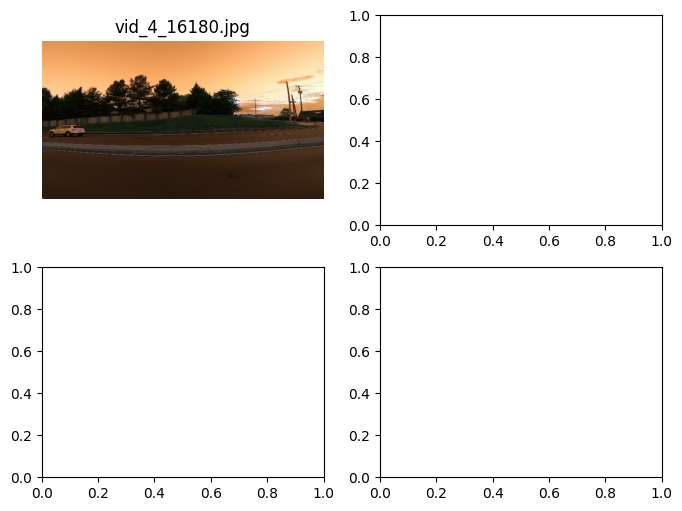

In [29]:
import random

def plot_random_predictions(image_dir, model, n=4):
    # list of all images in the directory
    all_images = os.listdir(image_dir)

    # randomly select images
    selected_images = random.sample(all_images, min(n, len(all_images)))

    # set up a 3x3 grid
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    axes = axes.flatten()

    for i, img_name in enumerate(selected_images):
        # load
        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # predict
        results = model.predict(img_path)

        # plot
        plotted_img = results[0].plot()  # Assumes one set of results per image

        # show
        axes[i].imshow(plotted_img)
        axes[i].set_title(img_name)
        axes[i].axis('off')

    # hide any unused subplots
    for j in range(len(selected_images), 4):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

images_dir = test_data
plot_random_predictions(image_dir=images_dir, model=model)


image 1/1 /Users/renatoboemer/code/developer/object-tracking/yolov8/data/images/val_images/vid_4_600.jpg: 384x640 (no detections), 373.6ms
Speed: 2.2ms preprocess, 373.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


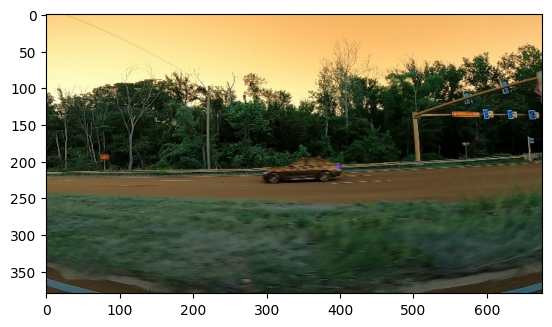

In [36]:
img_path = "img_path.jpg"
r = model.predict(img_path)
plotted_img = r[0].plot()
plt.imshow(plotted_img)